# EfficientDet Training On A Custom Dataset



<table align="left"><td>
  <a target="_blank"  href="https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/blob/master/tutorial/train_logo.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.research.google.com/github/zylo117/Yet-Another-EfficientDet-Pytorch/blob/master/tutorial/train_logo.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

## This tutorial will show you how to train a custom dataset.

## Please enable GPU support to accelerate on notebook setting if you are using colab.

### 0. Install Requirements

In [ ]:
!pip install pycocotools numpy==1.16.0 opencv-python tqdm tensorboard tensorboardX pyyaml webcolors matplotlib

### 1. Prepare Custom Dataset/Pretrained Weights (Skip this part if you already have datasets and weights of your own)

In [1]:
import os
import sys
if "projects" not in os.getcwd():
  !git clone --depth 1 https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch
  os.chdir('Yet-Another-EfficientDet-Pytorch')
  sys.path.append('.')
else:
  !git pull

# download and unzip dataset
! mkdir datasets
! wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.1/dataset_birdview_vehicles.zip
! unzip -d datasets/ dataset_birdview_vehicles.zip

# download pretrained weights
! mkdir weights
! wget https://github.com/zylo117/Yet-Another-EfficientDet-Pytorch/releases/download/1.0/efficientdet-d0.pth -O weights/efficientdet-d0.pth

# prepare project file projects/logo.yml
# showing its contents here
! cat projects/birdview_vehicles.yml

Cloning into 'Yet-Another-EfficientDet-Pytorch'...
^C


FileNotFoundError: [Errno 2] No such file or directory: 'Yet-Another-EfficientDet-Pytorch'

### 2. Training

In [6]:
# consider this is a simple dataset, train head will be enough.
! python train.py -c 2 -p birdview_vehicles --head_only True --lr 5e-3 --batch_size 32 --load_weights weights/efficientdet-d2.pth  --num_epochs 10 --save_interval 100 --debug True

# the loss will be high at first
# don't panic, be patient,
# just wait for a little bit longer

UnboundLocalError: local variable 'child' referenced before assignment

In [7]:
! python train.py -c 0 -p birdview_vehicles --head_only False --lr 1e-3 --batch_size 16 --load_weights last  --num_epochs 16 --save_interval 100 --debug True

loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.11s)
creating index...
index created!
using weights logs//birdview_vehicles/efficientdet-d0_8_306.pth
[Info] loaded weights: efficientdet-d0_8_306.pth, resuming checkpoint from step: 306
Step: 344. Epoch: 4/16. Iteration: 69/69. Cls loss: 0.29415. Reg loss: 1.46513. 
Val. Epoch: 4/16. Classification loss: 3.62593. Regression loss: 10.07974. Total loss: 13.70567
Step: 399. Epoch: 5/16. Iteration: 55/69. Cls loss: 0.24812. Reg loss: 1.41023. checkpoint...
Step: 413. Epoch: 5/16. Iteration: 69/69. Cls loss: 0.23804. Reg loss: 1.12343. 
Val. Epoch: 5/16. Classification loss: 0.53766. Regression loss: 1.94766. Total loss: 2.48533
Step: 425. Epoch: 6/16. Iteration: 12/69. Cls loss: 0.17320. Reg loss: 1.07531. ^C
Step: 425. Epoch: 6/16. Iteration: 12/69. Cls loss: 0.17320. Reg loss: 1.07531. 


### 3. Evaluation

In [1]:
#get latest weight file
# %cd logs/birdview_vehicles
weight_file = !ls -Art | grep efficientdet
%cd ../..

#uncomment the next line to specify a weight file
# weight_file[-1] = 'efficientdet-d0_49_1400.pth'

! python coco_eval.py -c 0 -p birdview_vehicles -w "logs/birdview_vehicles/{weight_file[-1]}"

/home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch-master/logs/birdview_vehicles
/home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch-master
running coco-style evaluation on project birdview_vehicles, weights logs/birdview_vehicles/efficientdet-d0_8_306.pth...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
100%|█████████████████████████████████████████| 249/249 [00:16<00:00, 14.89it/s]
Loading and preparing results...
DONE (t=1.69s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=10.41s).
Accumulating evaluation results...
DONE (t=0.47s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.160
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.015
 Average Precis

### 4. Visualize

/home/mazheng/miniconda3/envs/eff/lib/python3.7/site-packages/ipykernel_launcher.py:71: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


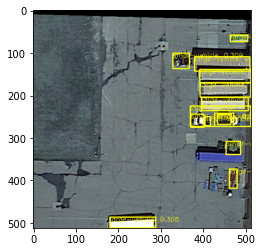

In [3]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes
from utils.utils import preprocess, invert_affine, postprocess

compound_coef = 2
force_input_size = None  # set None to use default size
img_path = 'datasets/birdview_vehicles/train/9.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True

obj_list = [ 'large-vehicle', 'small-vehicle' ]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(0.7, 1.4), (1.0, 1.0), (1.5, 0.7)],
                             scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/birdview_vehicles/'+'efficientdet-d2_8_300.pth'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)

out = invert_affine(framed_metas, out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])

